In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from roler.model import ModelPrior
from roler.distributions import *

prior = ModelPrior(
    individuals_local=IntDistribution(100, 10000),
    add_individuals_meta=IntDistribution(100, 10000),
    species_meta=IntDistribution(10, 500),
    speciation_local=FloatDistribution(0.0, 1e-4),
    mutation_rate=FloatDistribution(1e-7, 1e-5),
)

/Users/micahtilton/Documents/GitHub/likelihood-free-inference/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
from roler.inference import RoleR

roler = RoleR(prior=prior, load_fp="data/posterior.pt")

In [9]:
obs = roler.observe()
prediction = roler.infer(obs["x_obs"])
print(f"True           : {obs["theta_true"]}")
print(f"Posterior Mean : {prediction}")

# print(f"True           : {roler.get_params(obs["theta_true"]).model_dump_json(indent=4)}")
# print(f"Posterior Mean : {roler.get_params(prediction).model_dump_json(indent=4)}")

Drawing 10000 posterior samples: 10942it [00:00, 178711.76it/s]           

True           : tensor([5.4539e+02, 6.2569e+03, 3.4186e+01, 2.4458e-05, 6.1975e-06])
Posterior Mean : tensor([2.5248e+03, 5.0462e+03, 6.4977e+01, 4.8651e-05, 5.1448e-06])


In [ ]:
dataset = roler.generator.generate_dataset(100, n_jobs=14)

/var/folders/b7/t6qqglw97zl2pv5pmv_jtn040000gn/T/ipykernel_77994/252077781.py:7: UserWarning: Number of SBC samples should be on the order of 100s to give realiable results.
  ranks, dap_samples = run_sbc(
Drawing 10000 posterior samples: 10033it [00:06, 1509.35it/s]                          
Calculating ranks for 99 sbc samples.: 100%|██████████| 99/99 [00:00<00:00, 9209.05it/s]


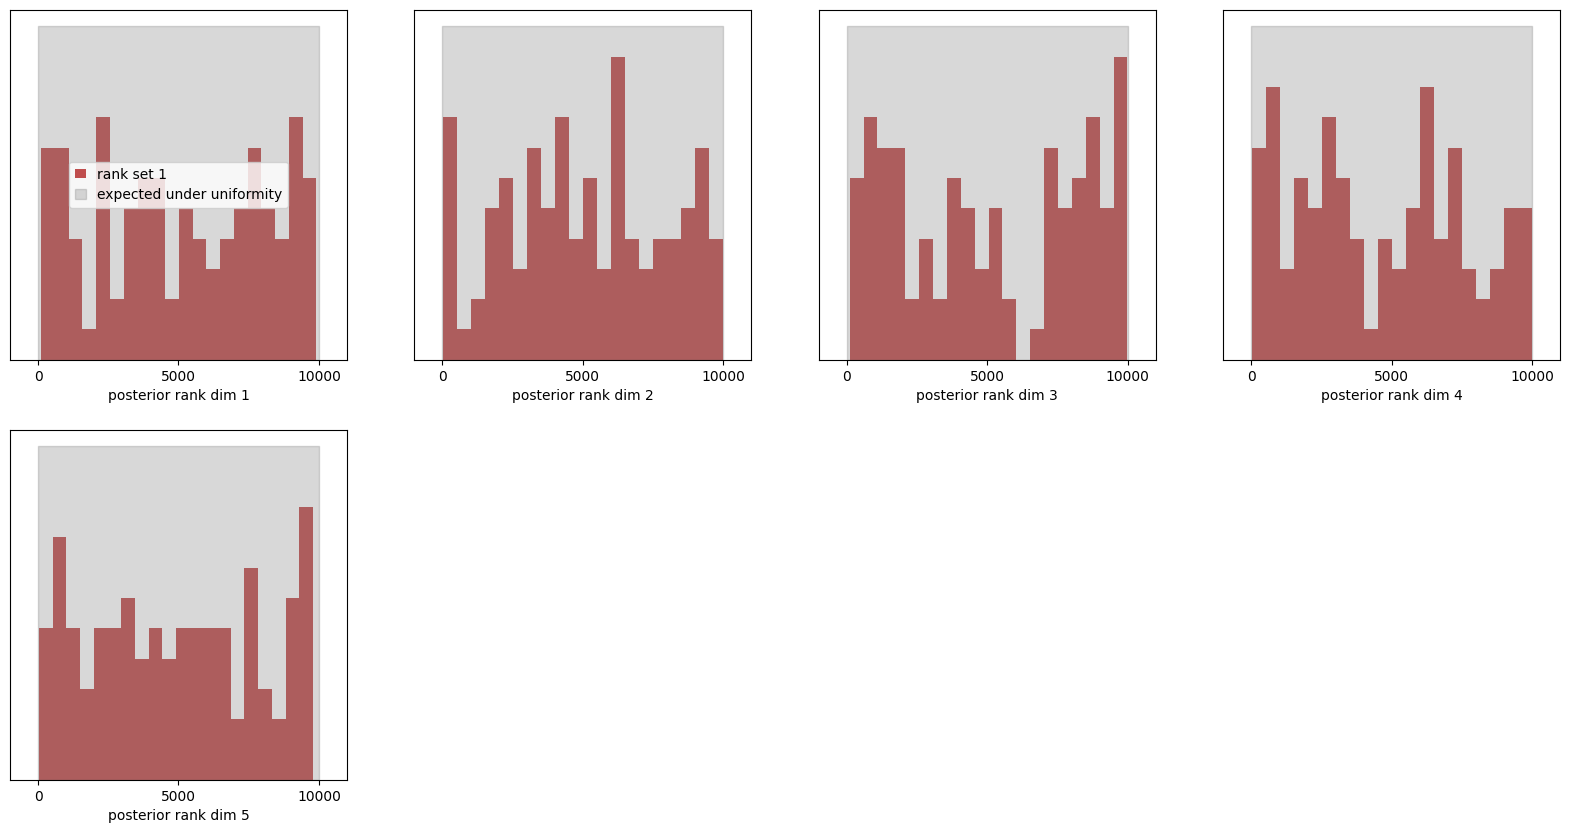

In [18]:
from sbi.diagnostics import run_sbc
from sbi.analysis    import sbc_rank_plot

thetas, xs = roler.to_tensor(dataset)

# 3) run SBC
ranks, dap_samples = run_sbc(
    thetas,
    xs,
    roler.posterior,                   # your trained, amortized posterior
    num_posterior_samples=10000  # how many draws per run
)

# 4) plot the rank histograms (should lie in the uniform confidence bands)
fig, axes = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=10000,
    plot_type="hist",
    num_bins=20
)

In [ ]:
import numpy as np
from scipy.stats import kstest

K = 10000  # e.g. 1000
flat = ranks.view(-1).cpu().numpy()
flat_norm = flat / float(K - 1)    # now in [0,1]
stat, pval = kstest(flat_norm, "uniform")
print("KS stat:", stat, "p-value:", pval)

KS stat: 0.034303432763224895 p‑value: 0.5927007007062133


When you plot your SBC rank histogram, you’re looking to see whether the ranks of your “true” parameters within their inferred posteriors are uniformly distributed. Here’s how to read it:
	1.	Axes
	•	Horizontal (bins): Each bin i counts how many times the true parameter fell at rank i among your K posterior samples.
	•	Vertical: The frequency (usually normalized to probability or fraction of runs) of each rank.
	2.	Ideal (flat) shape
	•	If your posterior is perfectly calibrated, the histogram will be approximately flat—every rank from 0 through K\!-\!1 is equally likely.
	•	A flat line means that, across all simulation draws, the true parameter is just as likely to be the 1st, 2nd, …, or Kth sample out of K.
	3.	Common deviations
	•	U‑shape (↑ at the leftmost and rightmost bins):
	•	Your posteriors are too narrow (overconfident). The true value often lies outside the bulk of your posterior draws, so it gets “pushed” into the extreme bins.
	•	∩‑shape (↑ in the middle bins, ↓ at tails):
	•	Your posteriors are too wide (underconfident). The true value tends to sit near the center of your draws more often than uniform.
	•	Skew (tilt left or right):
	•	A slant toward the left (more low‐rank counts) means you’re overestimating your parameter (posterior is biased high), and vice versa.
	4.	Confidence bands
If your sbc_rank_plot call overlays, say, the 95 % “gray” bands around uniformity:
	•	Histogram within the bands: Deviations are statistically plausible given finite N.
	•	Bins escaping the bands: Evidence of miscalibration—your posterior systematically mis‐orients the true value.
	5.	Practical threshold
	•	Small wobbles inside the bands are fine.
	•	Large excursions beyond the bands (or consistent U/∩ patterns) suggest you need to adjust your network capacity, regularization, or training procedure.

⸻

Quick checklist when you see your SBC histogram:
	•	Flat & inside bands? → Well‑calibrated.
	•	U‑shaped (tails high)? → Overconfident (posterior too narrow).
	•	Inverted‑U (center high)? → Underconfident (posterior too broad).
	•	Tilted? → Systematic bias (means off).
	•	Bins outside bands? → Statistically significant miscalibration.

Use that as your diagnostic guide: once your SBC rank histogram looks flat within its confidence bands, you can trust that your neural posterior is properly calibrated.

That’s actually great news—your flattened‐ranks KS test is showing no evidence against uniformity:
	•	KS stat ≈ 0.034 is a very small maximum distance from the uniform CDF.
	•	p ≈ 0.59 means you cannot reject the null hypothesis of “uniform,” so your ranks are consistent with perfect calibration.

In other words, your SBC histogram really is uniform up to random noise.  At this point you can be confident your neural posterior is well–calibrated. If you want to go further, the next steps are:
	1.	Per‑dimension KS tests (to catch any marginal quirks).
	2.	Credible‑interval coverage at various levels (50 %, 80 %, 90 %) on your SBC draws.
	3.	Posterior predictive checks to ensure your model actually reproduces observed data distributions.

But as it stands, a KS p‑value of 0.59 is exactly what you want to see. Nice work!

It all comes down to what your null hypothesis is:
	•	In most “difference” or “effect” tests, your null is “no difference,” so a low p‑value is “good” because it means you’ve rejected “no difference” in favor of an effect.
	•	Here, your null is “the SBC ranks are uniformly distributed” (i.e. perfectly calibrated). A high p‑value means you cannot reject that uniformity—so it’s good news for calibration!

Concretely:
	•	Low p (say < 0.05) → ranks not uniform → evidence of miscalibration (bad).
	•	High p (≫ 0.05) → no evidence against uniformity → posterior seems well calibrated (good).

So your p ≈ 0.59 is exactly what you want: it tells you your observed rank histogram is statistically consistent with a uniform distribution.